In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_base = pd.read_csv("Risk_Analysis.csv")
df_base.head()

,ConditionsSky,NumberStruckActual,WildlifeSize,AlertScore,Risk
0,No Cloud,859,Medium,1729,High
1,Some Cloud,424,Small,429,High
2,No Cloud,261,Small,263,High
3,Some Cloud,806,Small,811,High
4,No Cloud,942,Small,944,High


### EDA

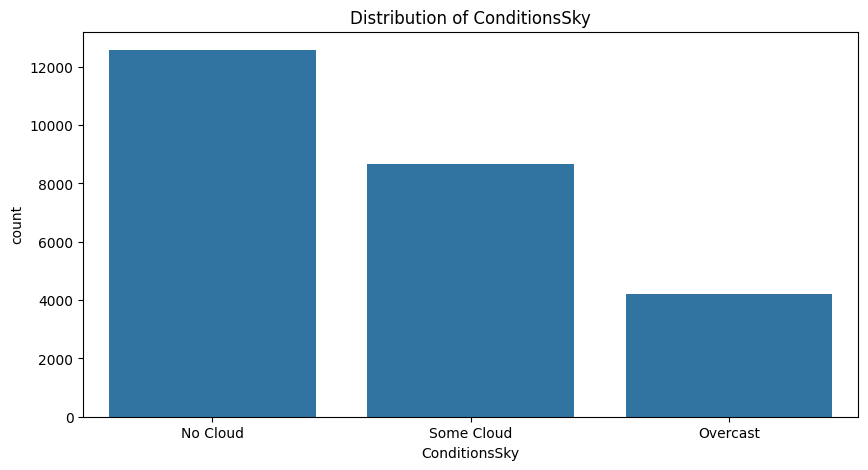

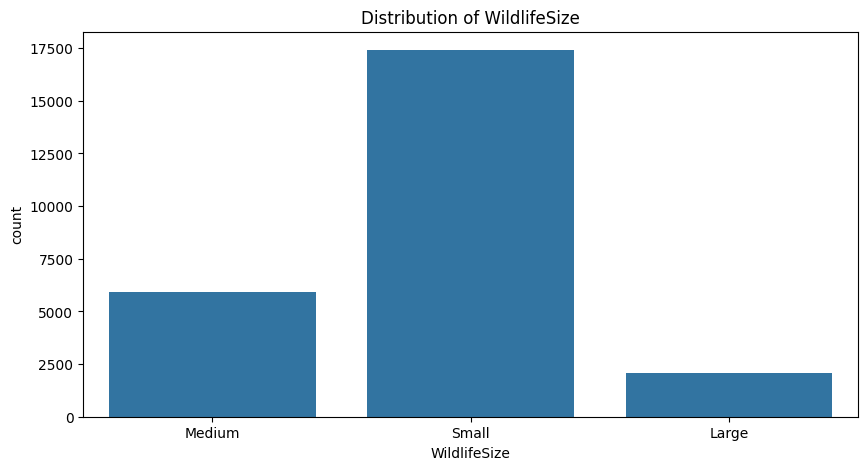

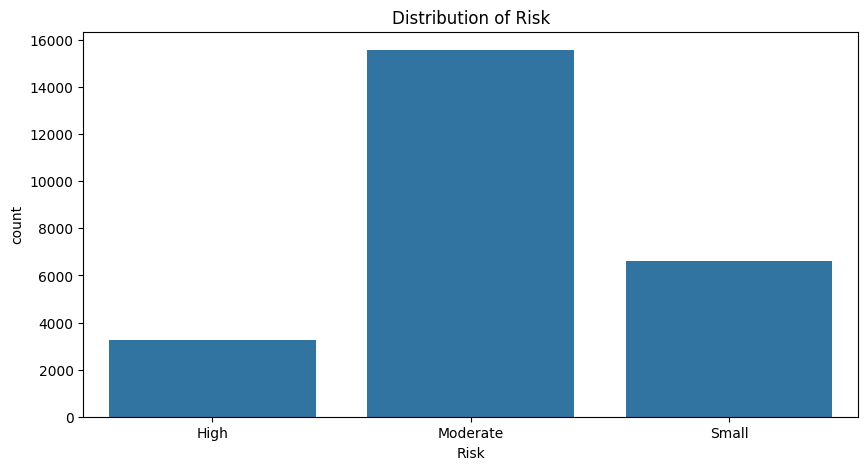

In [5]:
categorical_columns = ['ConditionsSky', 'WildlifeSize', 'Risk']

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_base, x=column)
    plt.title(f'Distribution of {column}')
    plt.show()

In [6]:
df_base.drop("AlertScore", axis=1, inplace=True)

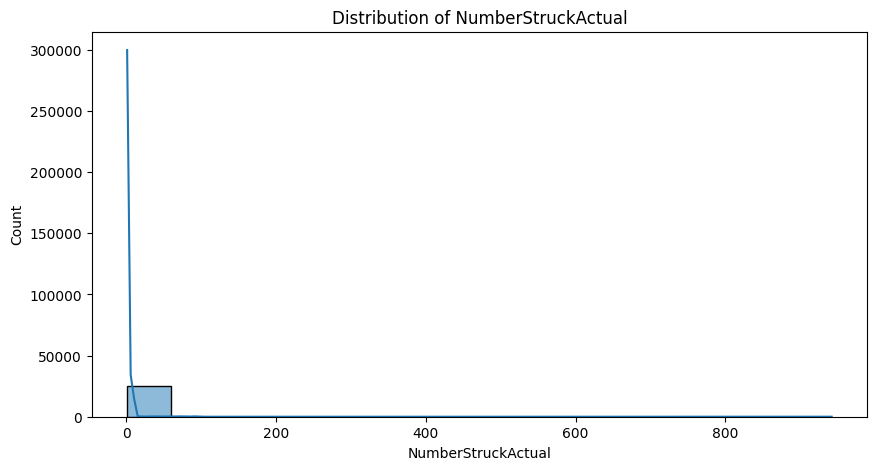

In [7]:
# plot the numerical numbers            
numerical_columns = ['NumberStruckActual']

for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_base, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()



In [8]:
from sklearn.preprocessing import OneHotEncoder

# Ordinal encoding for WildlifeSize and Risk
ordinal_mapping = {
    'WildlifeSize': {'Small': 0, 'Medium': 1, 'Large': 2},
    'Risk': {'Low': 0, 'Moderate': 1, 'High': 2}
}

df_ordinal = df_base.copy()
for column, mapping in ordinal_mapping.items():
    df_ordinal[column] = df_ordinal[column].map(mapping)

# One-hot encoding for ConditionsSky
one_hot_encoder = OneHotEncoder(sparse_output=False)
conditions_sky_encoded = one_hot_encoder.fit_transform(df_ordinal[['ConditionsSky']])
conditions_sky_encoded_df = pd.DataFrame(conditions_sky_encoded, columns=one_hot_encoder.get_feature_names_out(['ConditionsSky']))

# Combine the encoded columns with the rest of the dataframe
df_encoded = pd.concat([df_ordinal.drop('ConditionsSky', axis=1), conditions_sky_encoded_df], axis=1)

df_encoded.head()

,NumberStruckActual,WildlifeSize,Risk,ConditionsSky_No Cloud,ConditionsSky_Overcast,ConditionsSky_Some Cloud
0,859,1,2.0,1.0,0.0,0.0
1,424,0,2.0,0.0,0.0,1.0
2,261,0,2.0,1.0,0.0,0.0
3,806,0,2.0,0.0,0.0,1.0
4,942,0,2.0,1.0,0.0,0.0


Epoch 1/50


c:\Users\aashi\anaconda3\envs\falconeye\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8677 - loss: 0.4284 - val_accuracy: 0.9629 - val_loss: 0.1215
Epoch 2/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9701 - loss: 0.1134 - val_accuracy: 0.9678 - val_loss: 0.1140
Epoch 3/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9724 - loss: 0.1093 - val_accuracy: 0.9712 - val_loss: 0.1101
Epoch 4/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9719 - loss: 0.1126 - val_accuracy: 0.9717 - val_loss: 0.1072
Epoch 5/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9731 - loss: 0.1104 - val_accuracy: 0.9712 - val_loss: 0.1105
Epoch 6/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9703 - loss: 0.1129 - val_accuracy: 0.9720 - val_loss: 0.1063
Epoch 7/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.1130 - val_accuracy: 0.9717 - val_loss: 0.1052
Epoch 8/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9747 - loss: 0.1012 - val_accuracy: 0.9725 - val_

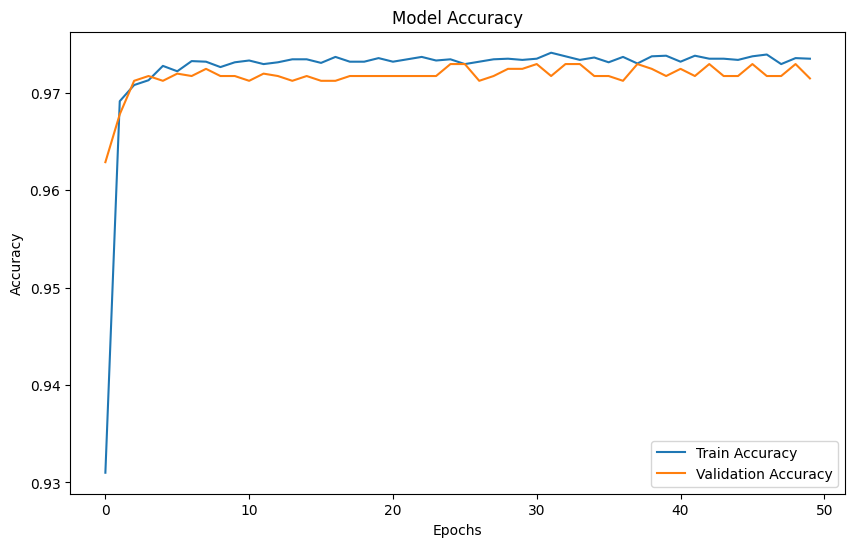

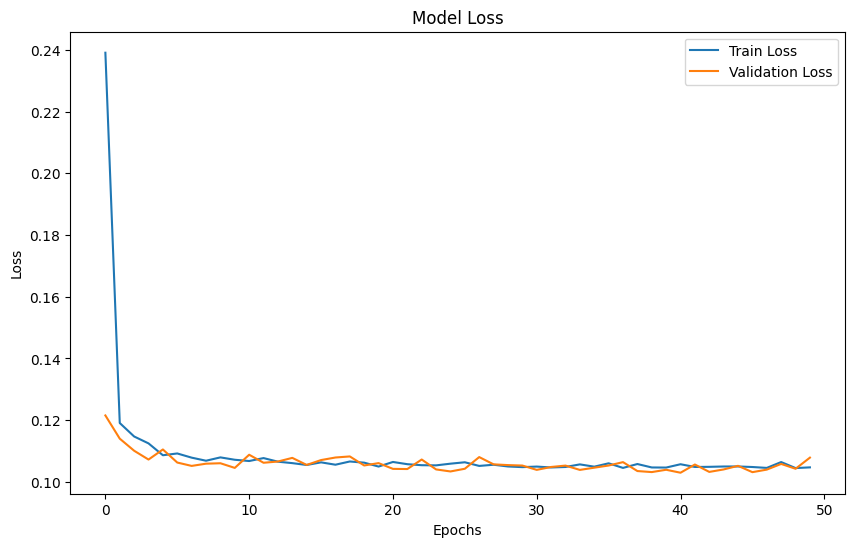

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Step 1: Separate features (X) and target variable (y)
X = df_encoded.drop(columns=['Risk'])  # All columns except Risk are features
y = df_encoded['Risk']  # Risk is the target variable

# Step 2: Ensure the target variable (y) is integer-encoded and then one-hot encode it
# Handle missing values in the target variable
y = y.fillna(y.mode()[0])  # Fill missing values with the most frequent value
y_integer_encoded = y.astype(int)  # Ensure y is integer-encoded
y_encoded = to_categorical(y_integer_encoded, num_classes=3)  # 3 classes: 0 (Low), 1 (Moderate), 2 (High)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 4: Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Build the Neural Network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Step 6: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classification Report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
    Moderate       0.97      1.00      0.99      4438
        High       1.00      0.80      0.89       648

    accuracy                           0.97      5086
   macro avg       0.66      0.60      0.62      5086
weighted avg       0.97      0.97      0.97      5086

Confusion Matrix:
[[4438    0]
 [ 131  517]]


C:\Users\aashi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aashi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aashi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

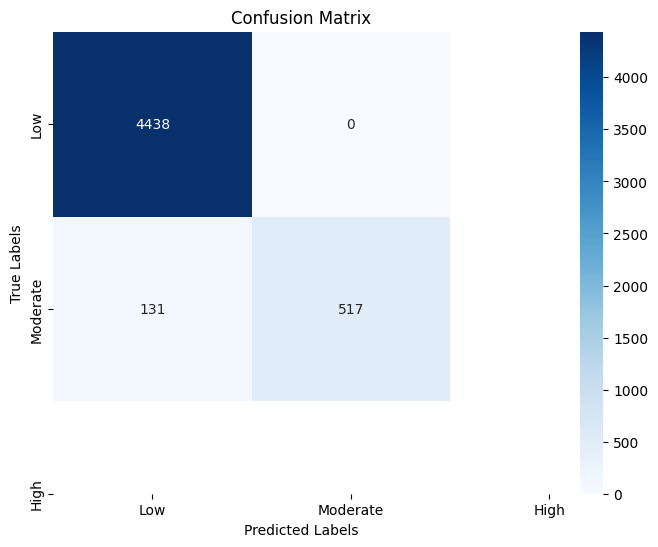

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 8: Evaluate the model and make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Low', 'Moderate', 'High'], labels=[0, 1, 2]))

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
